In [1]:
# import packages and clean the text file
import glob
import re
import os
from collections import Counter
import numpy as np
from tqdm import tqdm
import sentencepiece as spm

if not os.path.exists('/Users/celia/Desktop/biotokens/sentencepiece'):
    os.makedirs('/Users/celia/Desktop/biotokens/sentencepiece')

with open('/Users/celia/Desktop/biotokens/data/e_coli_genome.txt','r') as f:
    e = f.read()
e = e.split()
e = ''.join([i for i in e if len(i)==10 and re.sub('[acgt]','',i)==''])
print('genome size:',len(e))

genome size: 4641650


In [2]:
# process file into chunks for tokenizer. 
# L is the length of chunks- the maximum is 4192.
# Should check if results depend on L

L=4192
e2 = '\n'.join([e[k:k+L] for k in np.arange(0,len(e),L)])

with open('/Users/celia/Desktop/biotokens/data/e_coli_genome_processed.txt','w') as f:
    f.write(e2)

In [10]:
# fit tokenizer to genome for different vocab lengths
Nmax = 79961
# Nmax = 8800
for N in np.arange(1000,Nmax,1000):
    if not os.path.exists(f'/Users/celia/Desktop/biotokens/sentencepiece/ecoli_{N}.model'):
        spms = f'''--input=/Users/celia/Desktop/biotokens/data/e_coli_genome_processed.txt 
--model_prefix=/Users/celia/Desktop/biotokens/sentencepiece/ecoli_{N} 
--vocab_size={N}'''.replace('\n','')

        spm.SentencePieceTrainer.train(spms)


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/Users/celia/Desktop/biotokens/data/e_coli_genome_processed.txt --model_prefix=/Users/celia/Desktop/biotokens/sentencepiece/ecoli_10000 --vocab_size=10000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/celia/Desktop/biotokens/data/e_coli_genome_processed.txt
  input_format: 
  model_prefix: /Users/celia/Desktop/biotokens/sentencepiece/ecoli_10000
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0


In [4]:
#vocab size: 100
model_path = '/Users/celia/Desktop/biotokens/sentencepiece/ecoli_1000.model'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"model file {model_path} doesnt exist")

sp = spm.SentencePieceProcessor()
sp.load(model_path)
print('raw sequence:')

print(e[:100])
print('\ntokenized sequence:')
print(' '.join(sp.encode_as_pieces(e[:100])[1:]))
print('\ncorresponding tokens:')
print(' '.join([str(i) for i in sp.encode(e[:100])[1:]]))
print()
print('# tokens in genome:',len(sp.encode_as_pieces(e)))

raw sequence:
agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat

tokenized sequence:
agc ttt tcatt ctgact gca acg ggcaat atg tctct gtgt ggatt aaaa aaagag tgt ctgata gca gct tct gaactg gttacc tgccg tgagt aaat

corresponding tokens:
25 23 700 964 58 16 168 29 580 649 367 98 566 73 482 58 47 77 258 767 299 818 109

# tokens in genome: 1017199


In [9]:
#vocab size: 8,800
sp = spm.SentencePieceProcessor(model_file='sentencepiece/ecoli_8800.model')

print('raw sequence:')
print(e[:100])
print('\ntokenized sequence:')
print(' '.join(sp.encode_as_pieces(e[:100])[1:]))
print('\ncorresponding tokens:')
print(' '.join([str(i) for i in sp.encode(e[:100])[1:]]))
print()
print('# tokens in genome:',len(sp.encode_as_pieces(e)))

OSError: Not found: "sentencepiece/ecoli_8800.model": No such file or directory Error #2

In [6]:
#vocab size: 79,000
sp = spm.SentencePieceProcessor(model_file='sentencepiece/ecoli_79000.model')

print('raw sequence:')
print(e[:100])
print('\ntokenized sequence:')
print(' '.join(sp.encode_as_pieces(e[:100])[1:]))
print('\ncorresponding tokens:')
print(' '.join([str(i) for i in sp.encode(e[:100])[1:]]))
print()
print('# tokens in genome:',len(sp.encode_as_pieces(e)))

OSError: Not found: "sentencepiece/ecoli_79000.model": No such file or directory Error #2

In [7]:
# get N,L,V tuples for each tokenizer.
# N: vocab size
# L: genome length
# V: vocab length

NLV=[]
models = glob.glob('sentencepiece/ecoli_*.model')
for m in tqdm(models):
    
    N = int(m.split('_')[1].replace('.model',''))
    
    sp = spm.SentencePieceProcessor(model_file=m)
    L = len(sp.encode_as_pieces(e))
    
    with open(f'sentencepiece/ecoli_{N}.vocab','r') as f:
        vocab = f.read()
    vocab = [i.split('\t')[0] for i in 
             vocab.split('\n')[3:]]
    V = len('-'.join(vocab))
    
    NLV.append((N,L,V))
    
NLV = np.array(NLV)
NLV = NLV[np.argsort(NLV[:,0])]

0it [00:00, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

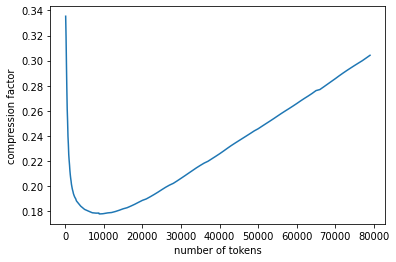

max compression vocab size: 8800


In [8]:
from matplotlib import pyplot as plt
Ns = NLV[:,0]
Ls = NLV[:,1]
Vs = NLV[:,2]

plt.plot(Ns,(Ls+Vs)/len(e))
plt.xlabel('number of tokens')
plt.ylabel('compression factor')

plt.show()

print('max compression vocab size:',Ns[np.argmin(Ls+Vs)])

In [9]:
# get token occurrence rate for best tokenizer
sp = spm.SentencePieceProcessor(
    model_file='sentencepiece/ecoli_8800.model')

toks = sp.encode_as_pieces(e)

tokcounts = Counter(toks).most_common()
tokcounts[:30]

[('c', 9854),
 ('gcg', 1189),
 ('ttt', 1116),
 ('ctgctg', 1113),
 ('cag', 942),
 ('gtt', 879),
 ('acgctg', 848),
 ('aac', 847),
 ('catcag', 794),
 ('cgcttt', 749),
 ('cgc', 744),
 ('aat', 739),
 ('aaacag', 715),
 ('attgcc', 714),
 ('atc', 710),
 ('ttc', 705),
 ('aaagcc', 705),
 ('gaa', 697),
 ('ggcgat', 664),
 ('gat', 663),
 ('gatatc', 658),
 ('cgt', 658),
 ('cagcaa', 658),
 ('cagcag', 651),
 ('atg', 646),
 ('act', 626),
 ('acg', 626),
 ('aaa', 621),
 ('cat', 619),
 ('gttgat', 614)]

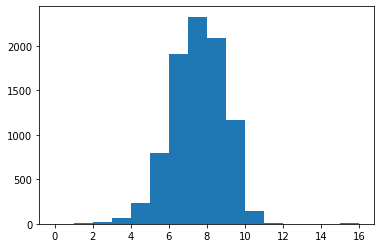

In [10]:
# token length distribution
plt.hist([len(t[0]) for t in tokcounts],
        bins=np.arange(0,max([len(t[0]) for t in tokcounts])+1))
plt.show()

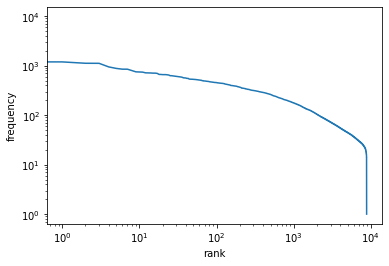

In [11]:
# plot rank-frequency curve
TC = [t[1] for t in tokcounts]
      #if len(t[0])==2]#[10:-1000]
plt.plot(np.arange(0,len(TC),1),TC)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

In [12]:
# get N,T tuples for each tokenizer.
# N: vocab size
# T: token counts

NT=[]
models = glob.glob('sentencepiece/ecoli_*.model')
for m in tqdm(models):
    N = int(m.split('_')[1].replace('.model',''))
    sp = spm.SentencePieceProcessor(model_file=m)
    toks = sp.encode_as_pieces(e)
    tokcounts = Counter(toks).most_common()


    NT.append((N,tokcounts))
    
NT = [NT[i] for i in np.argsort([n for n,t in NT])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [01:28<00:00,  1.40it/s]


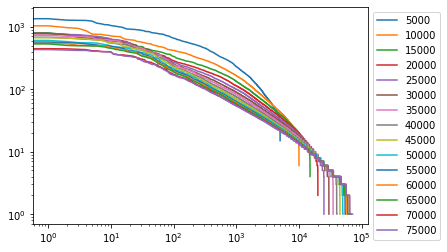

In [13]:
# plot rank-freqency curves for different tokenizers
for n,t in NT:
    if n%5000==0 and n<400000:
        plt.plot([c/t[1][1]**0 for _,c in t[1:-1]],label=n)

plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()